<a href="https://colab.research.google.com/github/vujjiniashrith/ESS-profit-maximaization-using-deep-Reinforcemetn-Learning/blob/main/DQN_openai_gym.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gym
import random


In [ ]:
from gym import Env
from gym import spaces
from gym.spaces import Discrete, Box


In [ ]:
data_elec = pd.read_csv("electicity_data_hourly.csv")
data_cons = pd.read_csv("consumer_data_hourly.csv")

In [ ]:
print(data_elec.columns)

Index(['datetime', 'system_energy_price_da'], dtype='object')


In [ ]:
print(data_cons.columns)

Index(['dateTime', 'use'], dtype='object')


In [ ]:
data_elec.head(6)

,datetime,system_energy_price_da
0,2022-01-01 00:00:00,21.02
1,2022-01-01 01:00:00,18.43
2,2022-01-01 02:00:00,18.11
3,2022-01-01 03:00:00,18.15
4,2022-01-01 04:00:00,17.70
5,2022-01-01 05:00:00,17.67


In [ ]:
data_elec.rename(columns={'system_energy_price_da':'price'},inplace = True)

In [ ]:
data_cons.rename(columns={'use':'usage'},inplace = True)

In [ ]:
data_cons.head()

,dateTime,usage
0,2016-01-01 00:00:00,2.108533
1,2016-01-01 01:00:00,1.852600
2,2016-01-01 02:00:00,1.988000
3,2016-01-01 03:00:00,1.993267
4,2016-01-01 04:00:00,1.781533


In [ ]:
print(data_cons.usage.max()," ",data_cons.usage.min())
print(data_elec.price.max()," ",data_elec.price.min())

29.8692   0.0
455.3   13.74


In [ ]:
print(data_cons.usage.median(), " ", data_cons.usage.mean())

3.519333333333332   5.361010481177894


In [ ]:
data_elec.shape

(8737, 2)

In [ ]:
data_cons.shape

(8784, 2)

In [ ]:
split_point = 7027
train_elec = data_elec[:split_point]
train_cons = data_cons[:split_point]
test_elec = data_elec[split_point:]
test_cons = data_cons[split_point:]
print(train_elec.shape, test_elec.shape)
print(train_cons.shape, test_cons.shape)

(7027, 2) (1710, 2)
(7027, 2) (1757, 2)


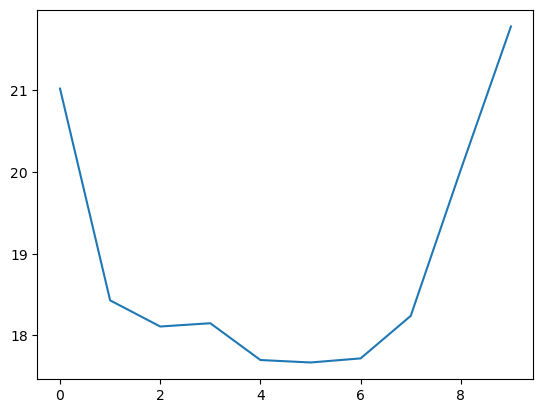

In [ ]:
plt.plot(data_elec.price[:10])

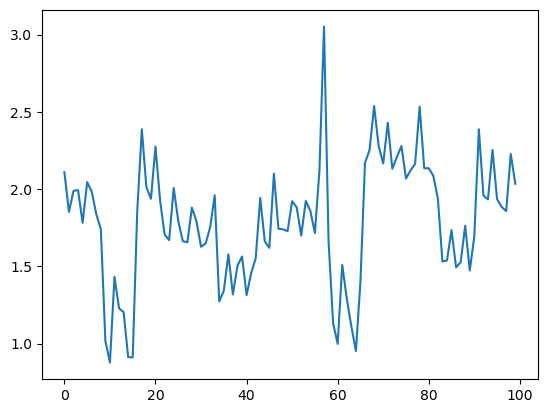

In [ ]:
plt.plot(data_cons.usage[0:100])

In [ ]:
data_usage = data_cons['usage'].values

In [ ]:
data_price = data_elec['price'].values

# Create Custom Environment of SmartGrid

In [ ]:
class SmartGrid(Env):
    def __init__(self,data_usage,data_price):
        #load electricity price data

        self.data_price = data_price

        #load consumer price data
        self.data_usage = data_usage

        #set maximum battery capacity
        self.max_capacity = 10

        #Actions that we can take
        #0 == -3, 1 == -2, 2 == -1, 3 ==0 , 4 == 1, 5 == 2, 6== 3 total 7 actions to take
        #-ve values stand for discharge and positive values stand for charge
        self.action_space = Discrete(7)

        #state
        self.observation_space = Box(low=np.array([0]), high=np.array([10]))

        #set initial start state
        self.state = 0

        #set initial position
        self.time_step = 0

        #initiate profits
        self.profits =0

        #action history
        self.action_history = []

        #profits history
        self.profits_history = []




    def step(self,action):
        reward=0
        self.state += action -3
        self.time_step+=1

        #calculate the profit

        self.profits = (3-action)*self.data_price[self.time_step]
        #calculate the reward
        if action==4 or action == 5 or action ==6:
            reward = (25-(3-action)*self.data_price[self.time_step])+self.punishment_for_bad_choices(action)
        else:
            reward = self.profits+self.punishment_for_bad_choices(action)

        #store the action in action_history
        self.action_history.append(action-3)
        self.profits_history.append(self.profits)

        if self.time_step>10:
            done = True
        else:
            done = False

        info = {}

        return self.state, reward, done, info

    def punishment_for_bad_choices(self,action):
        punishment = 0
        if(self.state<0):
            punishment = -100
        if(self.state>10):
            punishment = -100
        return punishment

    def render(self):
        #implement vizualization
        pass
    def reset(self):
        #reset the initial timestamp
        self.time_step =0
        #empty the entire battery
        self.state = 0
        #set done state as false
        self.action_history = []
        self.profits_history = []

        return self.state
    def get_action_history(self):
        return self.action_history

    def get_time_step(self):
        return self.time_step

    def get_profits_history(self):
        return self.profits_history


In [ ]:
env = SmartGrid(data_usage,data_price)

In [ ]:
env.observation_space.sample()

array([9.648768], dtype=float32)

In [ ]:
print(env.observation_space.shape)

(1,)


In [ ]:
episodes = 10
for episode in range(1,episodes+1):
    state = env.reset()
    done = False
    score = 0

    while not done:

        action = env.action_space.sample()
        n_state , reward, done, info = env.step(action)
        score+=reward
    print('Episode:{} Score:{}'.format(episode,score))
    action_history = env.get_action_history()
    print(action_history)
    print(env.get_profits_history())
    print(len(action_history),env.get_time_step())


Episode:1 Score:2.319999999999979
[0, 3, -1, 1, -3, -3, 2, 0, 3, -3, -1]
[0.0, -54.33, 18.15, -17.7, 53.010000000000005, 53.16, -36.48, 0.0, -65.34, 77.85, 26.3]
11 11
Episode:2 Score:-128.81
[2, -1, 0, -1, -1, -3, -1, 3, 2, -2, -3]
[-36.86, 18.11, 0.0, 17.7, 17.67, 53.16, 18.24, -60.09, -43.56, 51.9, 78.9]
11 11
Episode:3 Score:247.75
[-3, 2, 2, 1, 2, -1, 0, -1, 0, 3, -1]
[55.29, -36.22, -36.3, -17.7, -35.34, 17.72, 0.0, 20.03, 0.0, -77.85, 26.3]
11 11
Episode:4 Score:-102.25999999999988
[-1, -1, 0, -2, 3, -1, 2, 2, -1, 3, -3]
[18.43, 18.11, 0.0, 35.4, -53.010000000000005, 17.72, -36.48, -40.06, 21.78, -77.85, 78.9]
11 11
Episode:5 Score:477.39
[3, 3, 3, -3, -2, 2, 3, 3, 1, -3, 0]
[-55.29, -54.33, -54.449999999999996, 53.099999999999994, 35.34, -35.44, -54.72, -60.09, -21.78, 77.85, 0.0]
11 11
Episode:6 Score:207.42
[0, -2, 2, 2, 3, 1, 2, 2, 1, 3, -2]
[0.0, 36.22, -36.3, -35.4, -53.010000000000005, -17.72, -36.48, -40.06, -21.78, -77.85, 52.6]
11 11
Episode:7 Score:-586.88
[-1, 2, 0, 

# Creating Deep Learning Model with Keras

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

In [ ]:
states = env.observation_space.shape
actions = env.action_space.n

In [ ]:
del model

In [ ]:
print(states)
print(actions)

(1,)
7


In [ ]:
def build_model(states, actions):
    model = Sequential()

    model.add(Dense(24, activation='relu', input_shape=(1,)))  # Use input_shape as a tuple with a single integer
    model.add(Dense(24, activation='relu'))
    model.add(Dense(actions, activation='linear'))
    return model

In [ ]:
model = build_model(states, actions)

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 24)                48        
                                                                 
 dense_10 (Dense)            (None, 24)                600       
                                                                 
 dense_11 (Dense)            (None, 7)                 175       
                                                                 
Total params: 823
Trainable params: 823
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from rl.agents import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory

In [ ]:
def build_agent(model, actions):
    policy = BoltzmannQPolicy()
    memory = SequentialMemory(limit=50000, window_length=1)
    dqn = DQNAgent(model=model, memory=memory, policy=policy,
                  nb_actions=actions, nb_steps_warmup=10, target_model_update=1e-2)
    return dqn

In [ ]:
dqn = build_agent(model, actions)
dqn.compile(Adam(learning_rate=1e-3), metrics=['mae'])
dqn.fit(env, nb_steps=50000, visualize=False, verbose=1)

Training for 50000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 53s 5ms/step - reward: 34.1809
909 episodes - episode_reward: 375.939 [-659.840, 710.200] - loss: 7112.251 - mae: 296.217 - mean_q: 390.067

Interval 2 (10000 steps performed)
 2892/10000 [=======>......................] - ETA: 44s - reward: 37.6262

In [ ]:
scores = dqn.test(env, nb_episodes=10, visualize=False)
print(np.mean(scores.history['episode_reward']))

In [ ]:
print(env.get_action_history())

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
print(env.get_profits_history())